In [1]:
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Open the image using PIL
    img = Image.open(image_path)

    # Resize the image to the target size
    img = img.resize(target_size)

    # Convert the image to RGB (in case it's grayscale or has an alpha channel)
    img = img.convert('RGB')

    # Convert the image to a tensor
    img_tensor = transforms.ToTensor()(img)

    # Normalize the tensor
    img_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)

    # Add a batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor


def deprocess_image(x):
    x = x.squeeze().transpose(1, 2, 0)  # Remove .cpu() here
    x[:, :, 0] = x[:, :, 0] * 0.229 + 0.485
    x[:, :, 1] = x[:, :, 1] * 0.224 + 0.456
    x[:, :, 2] = x[:, :, 2] * 0.225 + 0.406
    return x


In [3]:
def content_loss(base_content, target):
    return torch.mean((base_content - target) ** 2)

def gram_matrix(input_tensor):
    result = torch.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    b, i, j, c = input_tensor.size()
    num_locations = b * i * j
    return result / num_locations

def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return torch.mean((gram_style - gram_target) ** 2)

In [4]:
class VGG19(nn.Module):
    def __init__(self, input_shape=(3, 224, 224)):
        super(VGG19, self).__init__()

        # Block 1
        self.block1_conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=1, padding=1)
        self.block1_conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.block2_conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.block2_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.block3_conv1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.block3_conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.block3_conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.block3_conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4
        self.block4_conv1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.block4_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block4_conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block4_conv4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5
        self.block5_conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block5_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block5_conv3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block5_conv4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.block5_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Top layers (Fully connected)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*7*7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.predictions = nn.Linear(4096, 1000)

    def forward(self, x):
        # Block 1
        x = F.relu(self.block1_conv1(x))
        x = F.relu(self.block1_conv2(x))
        x = self.block1_pool(x)

        # Block 2
        x = F.relu(self.block2_conv1(x))
        x = F.relu(self.block2_conv2(x))
        x = self.block2_pool(x)

        # Block 3
        x = F.relu(self.block3_conv1(x))
        x = F.relu(self.block3_conv2(x))
        x = F.relu(self.block3_conv3(x))
        x = F.relu(self.block3_conv4(x))
        x = self.block3_pool(x)

        # Block 4
        x = F.relu(self.block4_conv1(x))
        x = F.relu(self.block4_conv2(x))
        x = F.relu(self.block4_conv3(x))
        x = F.relu(self.block4_conv4(x))
        x = self.block4_pool(x)

        # Block 5
        x = F.relu(self.block5_conv1(x))
        x = F.relu(self.block5_conv2(x))
        x = F.relu(self.block5_conv3(x))
        x = F.relu(self.block5_conv4(x))
        x = self.block5_pool(x)

        # Top layers (Fully connected)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.predictions(x)

In [5]:
# Define constants
CONTENT_LAYER = 'block4_conv2'
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def get_content_and_style_models(vgg_model, content_layer = CONTENT_LAYER, style_layers = STYLE_LAYERS):

    # Extracting content layer
    content_model = nn.Sequential(*[getattr(vgg_model, layer) for layer in list(vgg_model._modules.keys())[:list(vgg_model._modules.keys()).index(content_layer) + 1]])

    # Extracting style layers
    style_models = []
    for style_layer in style_layers:
        style_model = nn.Sequential(*[getattr(vgg_model, layer) for layer in list(vgg_model._modules.keys())[:list(vgg_model._modules.keys()).index(style_layer) + 1]])
        style_models.append(style_model)

    return content_model, style_models

In [6]:
def compute_loss_and_gradients(combined_image, content_model, style_models, content_target, style_targets, content_weight, style_weight):
    combined_image.requires_grad_(True)

    # Get current content and style of the combined image
    current_content = content_model(combined_image)
    current_styles = [style_model(combined_image) for style_model in style_models]

    # Content loss
    c_loss = content_loss(current_content, content_target)

    # Style loss
    s_loss = sum([style_loss(current_styles[i], style_targets[i]) for i in range(len(STYLE_LAYERS))])

    # Total loss
    total_loss = content_weight * c_loss + style_weight * s_loss

    # Backward pass
    total_loss.backward(retain_graph=True)

    return total_loss, combined_image.grad


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def neural_style_transfer(content_image_path, style_image_path, iterations=1000, content_weight=1e3, style_weight=1.0):

    # Create the VGG19 model and move it to the device
    vgg19_model = VGG19().to(device)
    content_model, style_models = get_content_and_style_models(vgg19_model)

    # Preprocess the images and move them to the device
    content_image = preprocess_image(content_image_path).to(device)
    style_image = preprocess_image(style_image_path).to(device)

    # Get the content and style targets
    content_target = content_model(content_image)
    style_targets = [gram_matrix(style_model(style_image)) for style_model in style_models]

    # Initialize combined image with the content image and move it to the device
    combined_image = content_image.clone().detach().requires_grad_(True).to(device)

    # Optimizer
    opt = optim.Adam([combined_image], lr=0.02)

    for i in range(iterations):
        opt.zero_grad()
        loss, grads = compute_loss_and_gradients(combined_image, content_model, style_models, content_target, style_targets, content_weight, style_weight)
        opt.step()
        if i % 100 == 0:
            print(f"Iteration {i}/{iterations}: loss={loss.item()}")

    return deprocess_image(combined_image.detach().cpu().numpy())

cuda


Iteration 0/3000: loss=2292406.5
Iteration 100/3000: loss=92888.9921875
Iteration 200/3000: loss=14282.2802734375
Iteration 300/3000: loss=4271.33154296875
Iteration 400/3000: loss=2212.609619140625
Iteration 500/3000: loss=1666.291259765625
Iteration 600/3000: loss=1481.39013671875
Iteration 700/3000: loss=1402.475830078125
Iteration 800/3000: loss=1364.244384765625
Iteration 900/3000: loss=1345.29052734375
Iteration 1000/3000: loss=1335.90869140625
Iteration 1100/3000: loss=1330.93408203125
Iteration 1200/3000: loss=1327.5765380859375
Iteration 1300/3000: loss=1324.275634765625
Iteration 1400/3000: loss=1319.9354248046875
Iteration 1500/3000: loss=1313.3553466796875
Iteration 1600/3000: loss=1302.6622314453125
Iteration 1700/3000: loss=1284.4976806640625
Iteration 1800/3000: loss=1252.66064453125
Iteration 1900/3000: loss=1196.1983642578125
Iteration 2000/3000: loss=1098.815185546875
Iteration 2100/3000: loss=947.732421875
Iteration 2200/3000: loss=762.907470703125
Iteration 2300/300

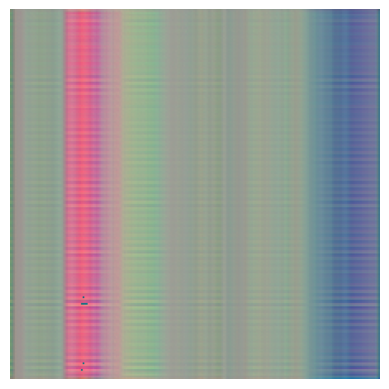

In [29]:
# Example usage:
output_image = neural_style_transfer("./white.jpg", "./fangao.jpeg", iterations=3000, content_weight=1, style_weight=1000000)
plt.imshow((output_image * 255).astype(np.uint8))   
plt.axis('off')
plt.show()